### This notebook shows step by step how water leaks of different severity can be detected

In [1]:
import os
import sys
import pytz
import inspect
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

from opengrid import config
from opengrid.library import plotting
from opengrid.library import houseprint

c=config.Config()

%matplotlib inline
plt.rcParams['figure.figsize'] = 16,8

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


#### Set start and end time for the analysis
Comment out if needed

In [2]:
# Original script
end = pd.Timestamp('2015/1/4')
start = end - dt.timedelta(days=60)
# Longer period, slower.
start = pd.Timestamp('20150101')
end = pd.Timestamp('20150430')
# March 2015, quick to run but very informative
start = pd.Timestamp('20150301')
end = pd.Timestamp('20150331')


In [3]:
hp = houseprint.Houseprint()
df = hp.get_data(sensortype='water', head=start, tail=end)
print("Unit of the data is {}".format(df[df.columns[0]].unit))

Opening connection to Houseprint sheet
Opening spreadsheets
Parsing spreadsheets
24 Sites created
24 Devices created
75 sensors created
Houseprint parsing complete
Using tmpo database from /mnt/data/work/opengrid/data/.tmpo/tmpo.sqlite3
Unit of the data is l/min


In [4]:
water_sensors = [sensor for sensor in hp.get_sensors('water') if sensor.key in df.columns]
print "{} water sensors".format(len(water_sensors))

7 water sensors


The purpose is to automatically detect leaks, undesired high consumption, etc.. so we can warn the user

Let's first have a look at the carpet plots in order to see whether we have such leaks, etc... in our database.

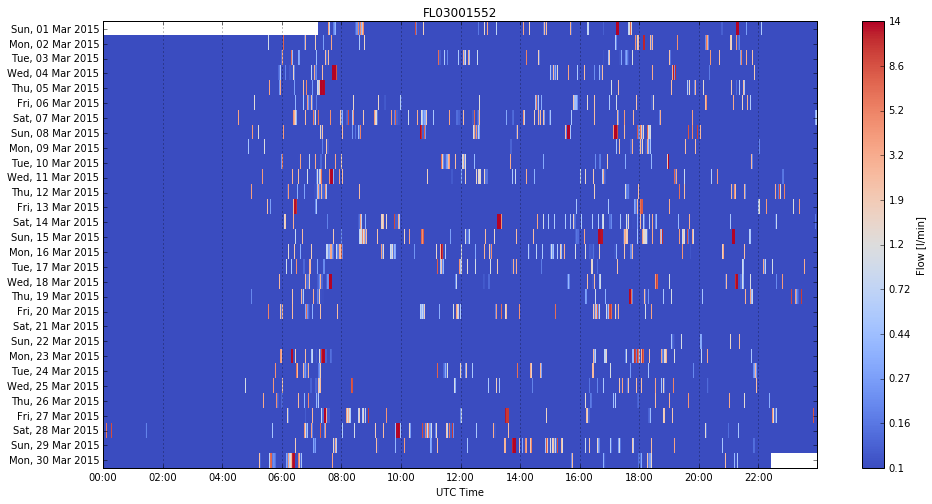

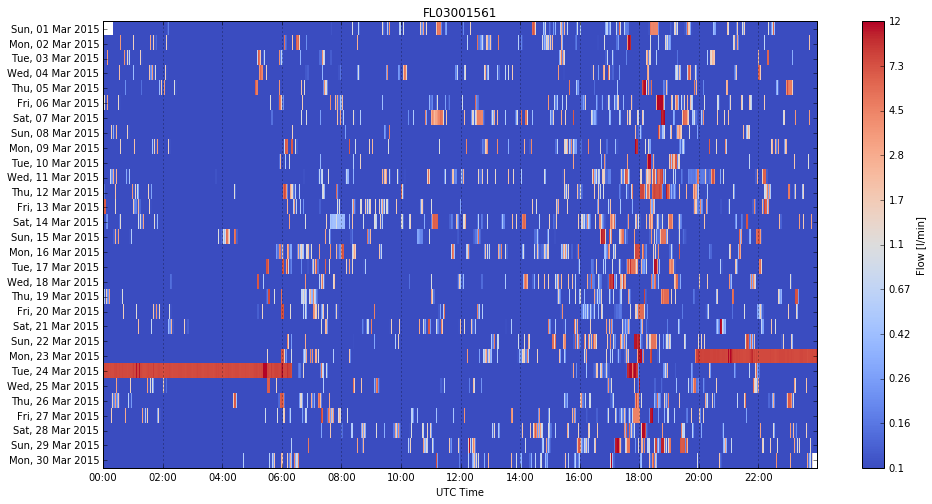

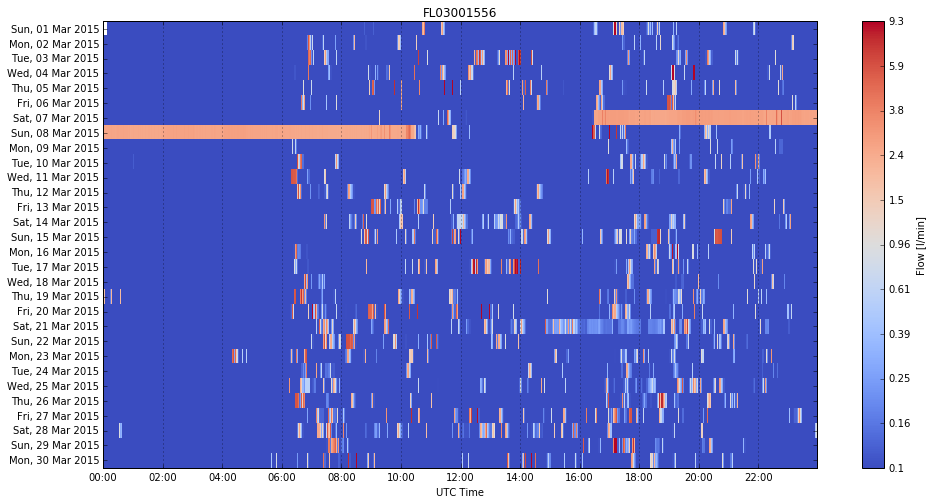

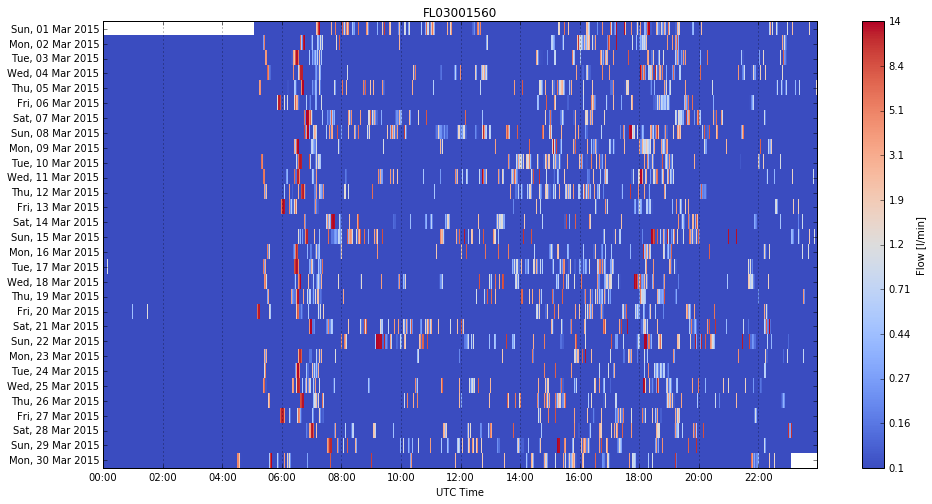

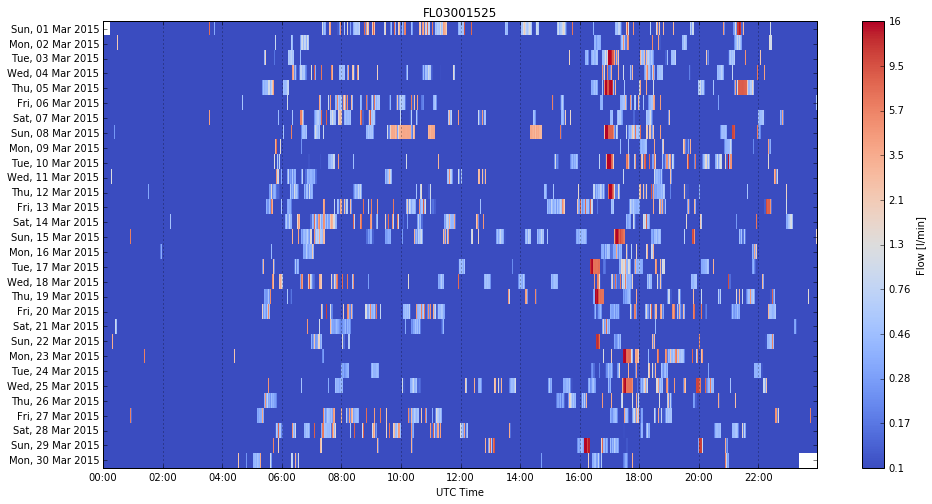

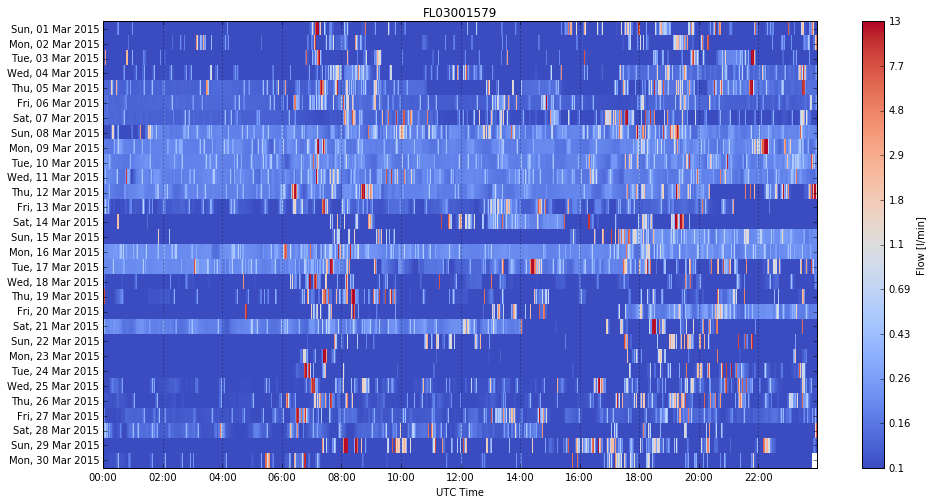

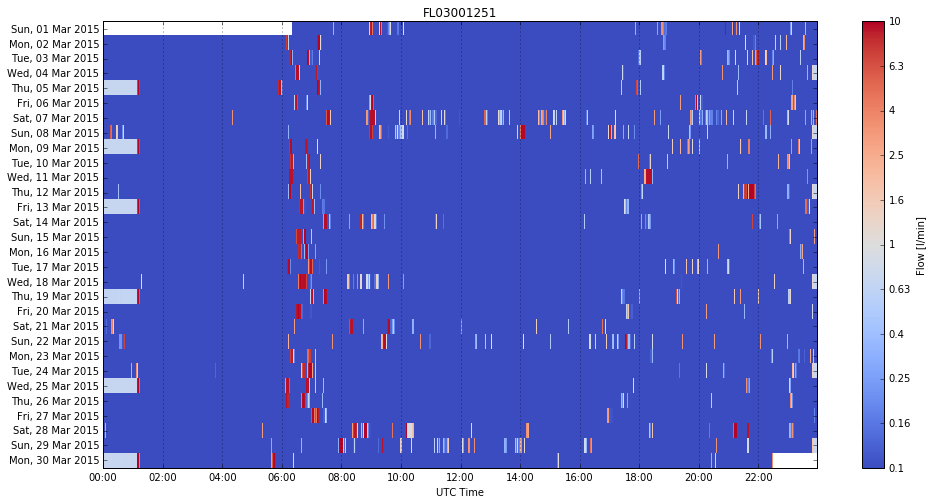

In [5]:
for sensor in water_sensors:
    ts = df[sensor.key]
    if not ts.dropna().empty:
        plotting.carpet(ts, title=sensor.device.key, zlabel=r'Flow [l/min]')


Yes, we do! The most obvious is FL03001579 with a more or less constant leak in the first month and later on some very large leaks during several hours. FL03001556 has a moderate leak once and seems to have similar, but less severe leaks later again. Also in FL03001561 there was once a strange (but rather short) issue and later on small, stubborn and irregularly deteriorating leaks of a different kind.

So, out of 6 water consumption profiles, there are 3 with possible leaks of different types and severities! This looks a very promising case to detect real issues and show the value of opengrid.

So, we would like to detect the following issues:
* FL03001579: constant leak in first month and big water leak during several hours on some days (toilet leaking?)
* FL03001556: moderate leak once and small water leak during several hours on some days (toilet leaking?)
* FL03001561: rather short leak and small, irregularly deteriorating water leak?

How could we detect these? Let's look first at the daily load curves of each sensor

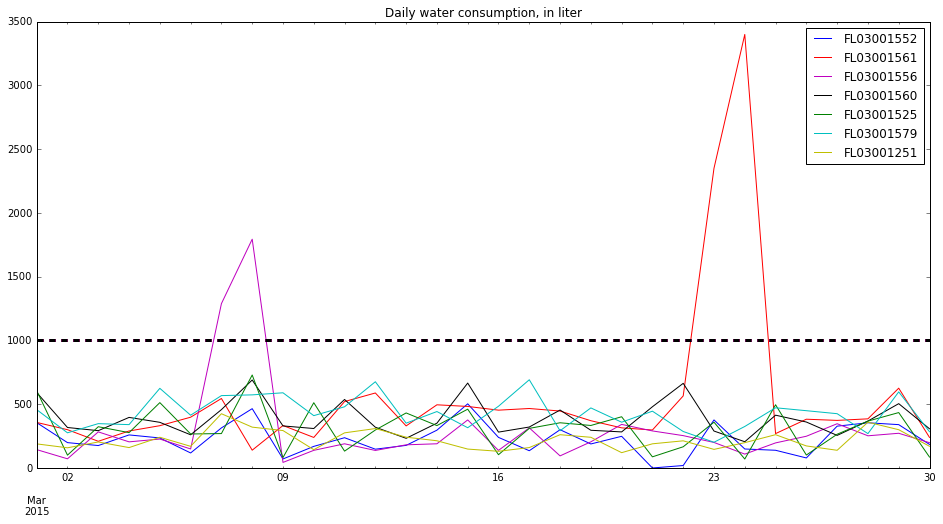

In [6]:
for sensor in water_sensors:
    ts = df[sensor.key]
    if not ts.dropna().empty:
        tsday = ts.resample('D', how='sum')
        tsday.plot(label=sensor.device.key)
        (tsday*0.+1000.).plot(style='--', lw=3, label='_nolegend_')
        plt.title('Daily water consumption, in liter')
        plt.legend()

So, the big water leaks of FL03001579 is relatively easy to detect, e.g. by raising an alarm as soon as the daily consumption exceeds 1500 l. However, by that time a lot of water has been wasted already.  One could lower the threshold a bit, but below 1000l a false alarm would be raised for FL03001525 on one day. Moreover, the other issues are not detected by such an alarm.

Let's try it in a different way. First have a look at the load duration curve, maybe there we could find something usefull for the alarm.

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:7: FutureWarning: order is deprecated, use sort_values(...)


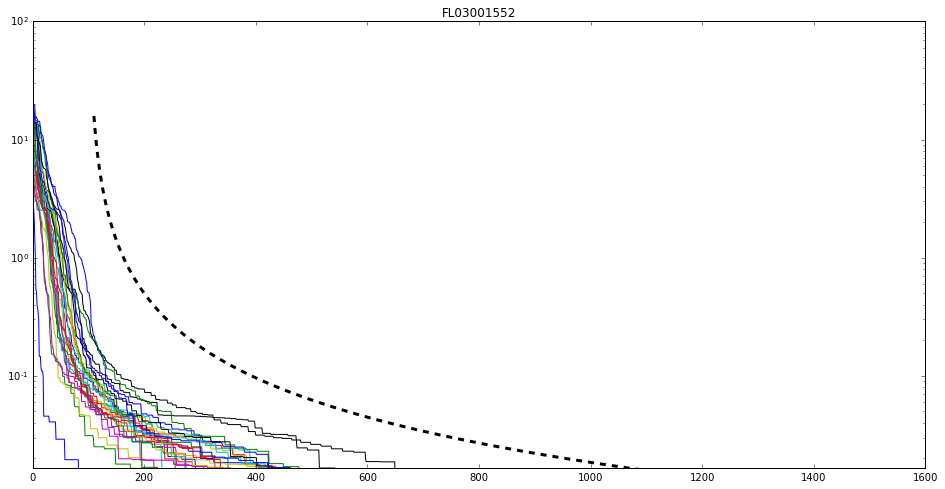

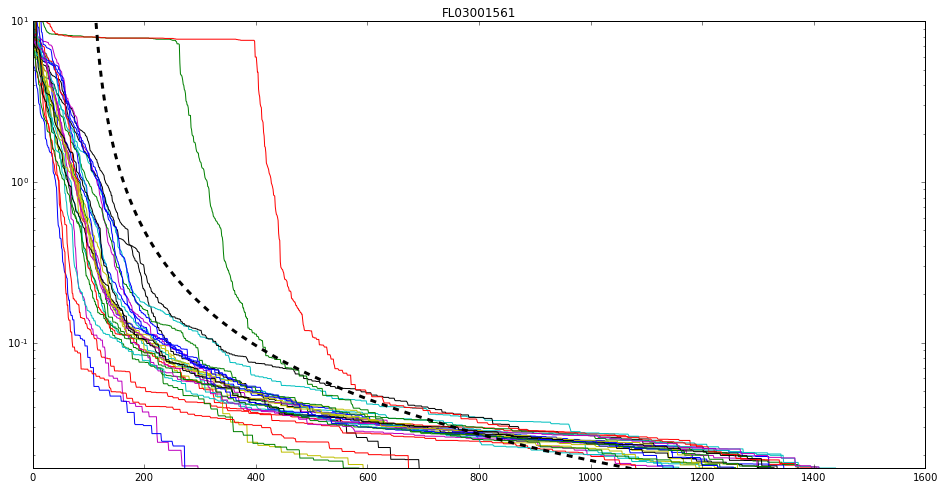

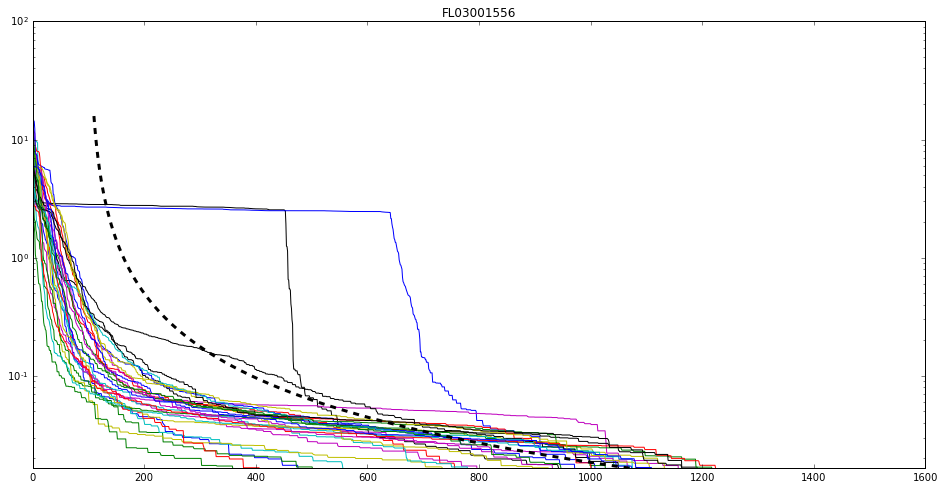

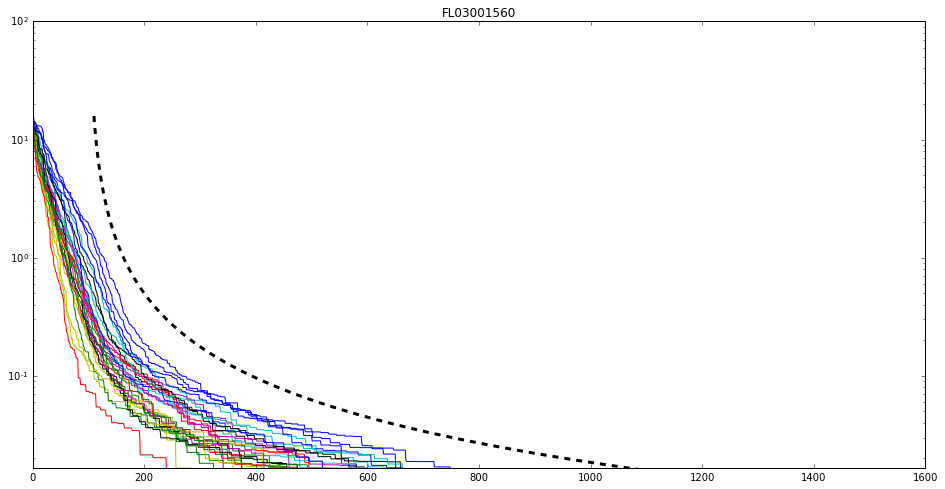

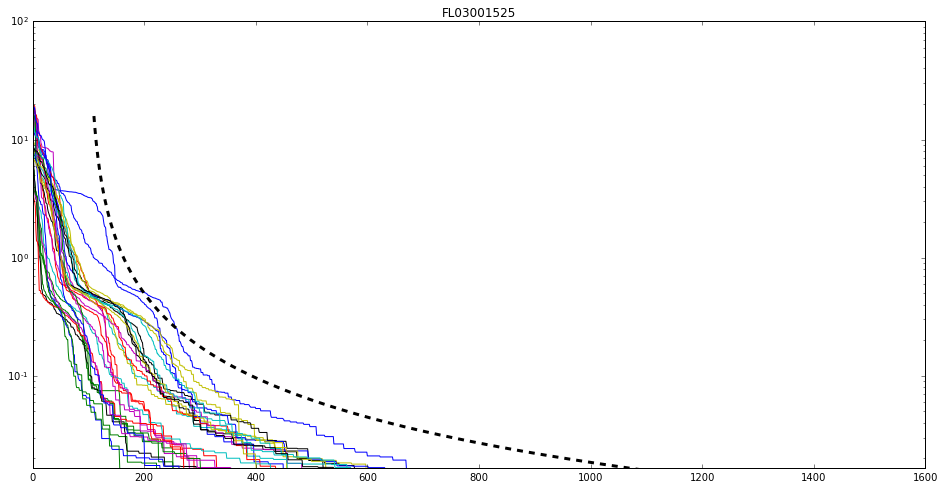

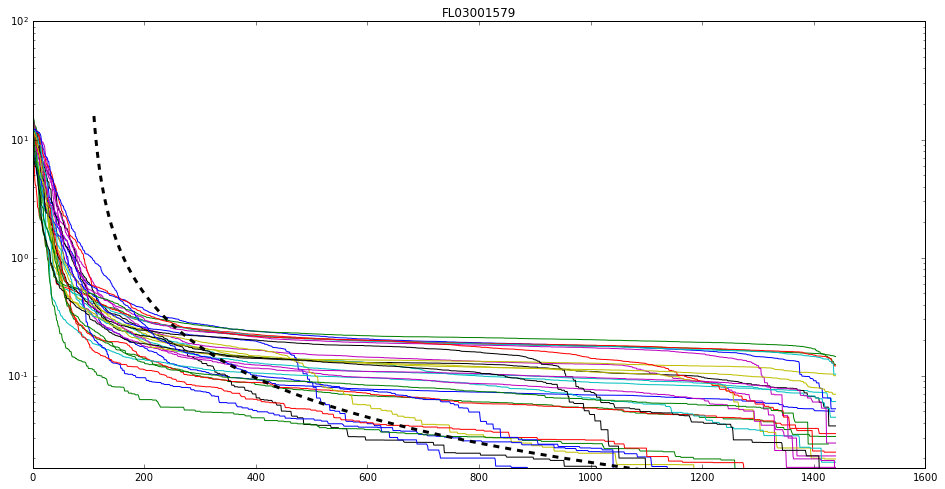

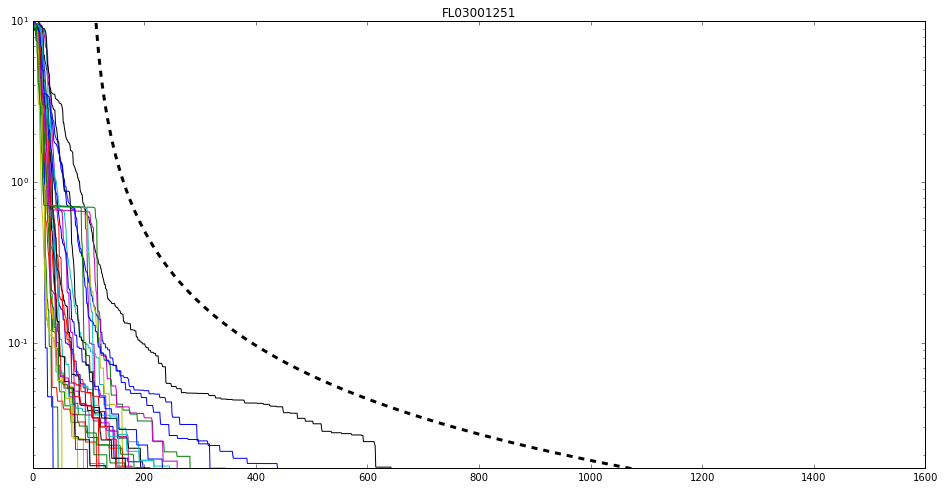

In [7]:
for sensor in water_sensors:
    ts = df[sensor.key]
    if not ts.dropna().empty:
        plt.figure()
        for day in pd.date_range(start, end):
            try:
                tsday = ts[day.strftime('%Y/%m/%d')].order(ascending=False) * 60.
                plt.plot(tsday.values/60.)
                x = np.arange(len(tsday.values)) + 10.
                plt.gca().set_yscale('log')
                plt.ylim(ymin=1/60.)
                plt.title(sensor.device.key)
            except:
                pass
        plt.plot(x + 100., 500./x**1.5, 'k--', lw=3)

This way, most of the issues could be detected, but some marginally. For small leaks it may take a full day before the alarm is raised.

Maybe we can improve this. A more reliable way may be to look for consecutive minutes with high load. So, let's have a look at the 60 minutes rolling minimum of the load.

In [ ]:
for sensor in water_sensors:
    ts = df[sensor.key] * 60.
    if not ts.dropna().empty:
        tsday = pd.rolling_min(ts, 60)
        ax = tsday.plot(label=sensor.device.key)
(tsday*0.+20.).plot(style='--', lw=3, label='_nolegend_')
plt.gca().set_yscale('log')
ax.set_ylim(ymin=1)
plt.legend()

The large leaks are very pronounced and easily detected (remark that this is a logarithmic scale!) one hour after the leak started. But the smaller leaks are still not visible.

Remark that a typical characteristic of a leak is that it is more or less constant, and thus the mean is probably pretty close to the minimum. An expected high load typically varies a lot more over one hour and thus its mean is probably a lot higher than its minimum. So, we could exploit this characteristic of leaks by subtracting some fraction of the rolling mean from the rolling minimum. Leaks should then stand out compared to normal loads.

In [ ]:
for sensor in water_sensors:
    ts = df[sensor.key] * 60.
    if not ts.dropna().empty:
        tsday = pd.rolling_min(ts, 60) - 0.3*pd.rolling_mean(ts, 60)
        ax = tsday.plot(label=sensor.device.key)
(tsday*0.+1.).plot(style='--', lw=3, label='_nolegend_')
ax.set_yscale('log')
ax.set_ylim(ymin=0.1)
plt.legend()

Now this works! The large leaks of FL03001579 stand out by two orders of magnitude, but also the small leaks of FL03001556 and FL03001561 are detected one hour after they started.